# House Price Analysis in Metropolitan Region of Fortaleza

## 1. Importing packages

In [38]:
!pip install pandas_profiling

In [129]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from pandas_profiling import ProfileReport
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pycep_correios
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 2. Web Scrappig the Data from OLX

### 2.1. Defining the parameters to be used

In [66]:
#Headers to be used to fake you are accessing by browser
headers = {
    'authority': 'ce.olx.com.br',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://ce.olx.com.br/fortaleza-e-regiao/imoveis?o=2',
    'sec-ch-ua': '"Chromium";v="104", " Not A;Brand";v="99", "Google Chrome";v="104"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36',
}
#parameter to navigate in the pages from our search
params = {
    'o': '2',
}

### 2.2. Collecting the houses urls 

In [67]:
def get_urls(page):
    """Function to collect the houses URLs from the page's html"""
    soup = BeautifulSoup(page.text, 'html.parser')
    properties = soup.find('div',{"id":'column-main-content'}).find_all("a", {"data-lurker-detail":"list_id"})
    link_list = []
    for item in properties:
        link_list.append(item['href'])
    return link_list

In [68]:
url = 'https://ce.olx.com.br/fortaleza-e-regiao/grande-fortaleza/imoveis/venda'
page = requests.get(url, headers=headers)
properties_urls = get_urls(page)
for i in range(2,105):
    params['o'] = str(i)
    page = requests.get(url,params=params, headers=headers)
    if page.status_code == 200:
        properties_urls = properties_urls + get_urls(page)
    time.sleep(5)
    print(len(properties_urls))

100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200


In [69]:
#Removing duplicates if exist
set_URLs = set(properties_urls)
print("Total with duplicates: "+str(len(properties_urls)))
print("Total without duplicates: "+str(len(set_URLs)))

Total with duplicates: 5200
Total without duplicates: 5000


In [70]:
df_URLs = pd.DataFrame(set_URLs)
df_URLs.to_csv('properties_URLs_Great_Fortaleza.csv', index=False, header=False)
df_URLs.head()

0
0  https://ce.olx.com.br/fortaleza-e-regiao/imove...
1  https://ce.olx.com.br/fortaleza-e-regiao/imove...
2  https://ce.olx.com.br/fortaleza-e-regiao/imove...
3  https://ce.olx.com.br/fortaleza-e-regiao/imove...
4  https://ce.olx.com.br/fortaleza-e-regiao/imove...

### 2.2. Access each URL and get the houses information

In [71]:
#Define functions to be used in the parse from the HTML of OLX
def get_Text_if_notNone(data):
    """If not None returns the text attribute else returns None"""
    if data is not None:
        return data.text
    else:
        return None

def get_Next_Element_Text_if_notNone(data):
    """If not None returns the text attribute of the next element else returns None"""
    if data is not None:
        return data.next_element.next_element.text
    else:
        return None

def ScrapData_to_DataFrameOLX(page, dfData):
    """Makes the parse of the HTML data to a dataframe format"""
    
    soup = BeautifulSoup(page.text, 'html.parser')
    Price = soup.find('div',{'data-testid':'ad-price-wrapper'})
    if Price is not None:
        Price = get_Text_if_notNone(Price.find('h2',class_='sc-1wimjbb-1 bQzdqU sc-ifAKCX cmFKIN'))
        if Price is None:
            return dfData
        elif Price == 'R$ 0':
            return dfData
    else:
        return dfData
    
    Description = get_Text_if_notNone(soup
                                      .find('div',class_='sc-1sj3nln-0 eSLnCp').
                                      find('span',class_='sc-1sj3nln-1 eOSweo sc-ifAKCX cmFKIN'))
    
    div_properties = soup.find_all('div',{'data-testid':'ad-properties'})
    
    Category = get_Next_Element_Text_if_notNone(div_properties[0]
                                                .find('dt',string='Categoria'))
    Type = get_Next_Element_Text_if_notNone(div_properties[0]
                                            .find('dt',string='Tipo'))
    Cond_Price = get_Next_Element_Text_if_notNone(div_properties[0]
                                                  .find('dt',string='Condomínio')) 
    IPTU_Price = get_Next_Element_Text_if_notNone(div_properties[0]
                                                  .find('dt',string='IPTU')) 
    Area = get_Next_Element_Text_if_notNone(div_properties[0]
                                            .find('dt',string='Área útil')) 
    if Area is None:
        Area = get_Next_Element_Text_if_notNone(div_properties[0]
                                            .find('dt',string='Área construída'))
    Bedrooms = get_Next_Element_Text_if_notNone(div_properties[0]
                                                .find('dt',string='Quartos')) 
    Bathrooms = get_Next_Element_Text_if_notNone(div_properties[0]
                                                 .find('dt',string='Banheiros'))
    Garage = get_Next_Element_Text_if_notNone(div_properties[0]
                                              .find('dt',string='Vagas na garagem')) 
    Property_Detail = get_Next_Element_Text_if_notNone(div_properties[0]
                                                       .find('dt',string='Detalhes do imóvel')) 
    Cond_Detail = get_Next_Element_Text_if_notNone(div_properties[0]
                                                   .find('dt',string='Detalhes do condominio'))   
    Zipcode = get_Next_Element_Text_if_notNone(div_properties[1]
                                               .find('dt',string='CEP'))    
    City = get_Next_Element_Text_if_notNone(div_properties[1]
                                            .find('dt',string='Município'))    
    Neighboor = get_Next_Element_Text_if_notNone(div_properties[1]
                                                 .find('dt',string='Bairro'))    
    Address = get_Next_Element_Text_if_notNone(div_properties[1]
                                               .find('dt',string='Logradouro'))    
    new_row = {'Category':Category,
               'Type':Type,
               'Cond_Price':Cond_Price,
               'IPTU_Price':IPTU_Price,
               'Area':Area,
               'Bedrooms':Bedrooms,
               'Bathrooms':Bathrooms,
               'Garage':Garage,
               'Property_Detail':Property_Detail,
               'Cond_Detail':Cond_Detail,
               'Price':Price,
               'Zipcode':Zipcode,
               'City':City,
               'Neighboor':Neighboor,
               'Address':Address, 
               'Description':Description}
    dfData = dfData.append(new_row, ignore_index = True)
    return dfData

In [72]:
properties_urls = list(set_URLs)

In [75]:
#Iterate over the set_URLs and access the URL and collect the data 
#and parse it to a dataframe
#df_Properties = pd.DataFrame(columns=['Category',
#                                      'Type',
#                                      'Cond_Price',
#                                      'IPTU_Price',
#                                      'Area',
#                                      'Bedrooms',
#                                      'Bathrooms',
#                                      'Garage',
#                                      'Property_Detail',
#                                      'Cond_Detail',
#                                      'Price',
#                                      'Zipcode',
#                                      'City',
#                                      'Neighboor',
#                                      'Address',
#                                      'Description'])
#count = 0
for item in properties_urls[2507:]:
    url = item
    page = requests.get(url, headers=headers)
    if page.status_code == 200:
        df_Properties = ScrapData_to_DataFrameOLX(page, df_Properties)
    wait_time = random.randrange(2, 10, 1) 
    time.sleep(wait_time)
    count=count+1
    if count%100 == 0:
        print(datetime.now())
        print(count)

2022-09-02 07:07:09.382370
2600
2022-09-02 07:18:05.052890
2700
2022-09-02 07:29:04.449947
2800
2022-09-02 07:39:36.286892
2900
2022-09-02 07:50:13.482597
3000
2022-09-02 08:01:49.954276
3100
2022-09-02 08:12:51.115730
3200
2022-09-02 09:05:45.353719
3300
2022-09-02 09:16:23.270385
3400
2022-09-02 09:27:41.338476
3500
2022-09-02 09:39:23.918536
3600
2022-09-02 09:51:18.144143
3700
2022-09-02 10:02:08.437350
3800
2022-09-02 10:14:10.604434
3900
2022-09-02 10:25:54.053977
4000
2022-09-02 10:37:01.844015
4100
2022-09-02 10:48:24.819468
4200
2022-09-02 10:59:19.764449
4300
2022-09-02 11:11:20.978921
4400
2022-09-02 11:22:06.081541
4500
2022-09-02 11:33:05.649793
4600
2022-09-02 11:43:17.522693
4700
2022-09-02 11:54:15.800717
4800
2022-09-02 12:05:57.779399
4900
2022-09-02 12:17:42.662457
5000


In [76]:
print(count)

5001


In [77]:
###
df_Properties.to_csv('properties_Data_Great_Fortaleza_3.csv', index=False)

In [161]:
###
df_data1 = pd.read_csv('properties_Data_Great_Fortaleza_3.csv')
df_data2 = pd.read_csv('properties_Data_Fortaleza_3.csv')
lst_df = [df_data1,df_data2]
df_Properties = pd.concat(lst_df, ignore_index=True, sort=False)

In [162]:
df_Properties.to_csv('olx_Great_Fortaleza_220830.csv', index=False)

In [82]:
####
df_Properties2 = df_Properties.drop_duplicates()

In [83]:
####
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9976
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         9908 non-null   object
 1   Type             9908 non-null   object
 2   Cond_Price       9490 non-null   object
 3   IPTU_Price       9235 non-null   object
 4   Area             9731 non-null   object
 5   Bedrooms         9908 non-null   object
 6   Bathrooms        9886 non-null   object
 7   Garage           9526 non-null   object
 8   Property_Detail  7190 non-null   object
 9   Cond_Detail      6838 non-null   object
 10  Price            9879 non-null   object
 11  Zipcode          9908 non-null   int64 
 12  City             9908 non-null   object
 13  Neighboor        6482 non-null   object
 14  Address          6355 non-null   object
 15  Description      9908 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.3+ MB


In [84]:
df_Properties2.head()

Category                                Type Cond_Price IPTU_Price  \
0         Casas  Venda - casa em condominio fechado       R$ 0       R$ 0   
1         Casas  Venda - casa em condominio fechado     R$ 449        NaN   
2         Casas  Venda - casa em condominio fechado     R$ 850       R$ 0   
3         Casas  Venda - casa em condominio fechado   R$ 1.150       R$ 0   
4  Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   

    Area Bedrooms  Bathrooms Garage  \
0  150m²        4          4      2   
1  230m²        4  5 ou mais      4   
2  210m²        4          4      3   
3  335m²        4          4      4   
4   50m²        2          1      1   

                                     Property_Detail  \
0  Churrasqueira, Piscina, Área de serviço, Ar co...   
1            Área de serviço, Varanda, Churrasqueira   
2             Porteiro 24h, Varanda, Ar condicionado   
3                           Piscina, Área de serviço   
4                                                NaN   

                                         Cond_Detail         Price   Zipcode  \
0                        Piscina, Condomínio fechado    R$ 569.000  61760000   
1  Condomínio fechado, Segurança 24h, Área murada...  R$ 1.350.000  61760000   
2               Permitido animais, Portão eletrônico    R$ 995.000  61760000   
3                                            Piscina  R$ 4.000.000  61760000   
4                                                NaN     R$ 35.000  61650290   

      City                    Neighboor     Address  \
0  Eusébio                          NaN         NaN   
1  Eusébio                          NaN         NaN   
2  Eusébio                          NaN         NaN   
3  Eusébio                          NaN         NaN   
4  Caucaia  Parque Guadalajara (Jurema)  Rua Poebla   

                                         Description  
0  Código do anúncio: CA0565\n\nRef.:5435 - Um lu...  
1  UMA CIDADE PENSADA PARA VOCÊ\n\nOcupando mais ...  
2  Código do anúncio: EUSEBIO1\n\nA casa de condo...  
3  Código do anúncio: 85\n\nALPHAVILLE - FORTALEZ...  
4  Código do anúncio: 1M0JU63\n\nRepasse no Potir...

In [85]:
#Separating the number from the currency symbol, so later we can transform to a numeric column
df_Properties2[['Price_Currency','Price_Value']] = df_Properties2["Price"].str.split(expand = True)
df_Properties2[['Cond_Currency','Cond_Value']] = df_Properties2["Cond_Price"].str.split(expand = True)
df_Properties2[['IPTU_Currency','IPTU_Value']] = df_Properties2["IPTU_Price"].str.split(expand = True)

In [86]:
df_Properties2.head()

Category                                Type Cond_Price IPTU_Price  \
0         Casas  Venda - casa em condominio fechado       R$ 0       R$ 0   
1         Casas  Venda - casa em condominio fechado     R$ 449        NaN   
2         Casas  Venda - casa em condominio fechado     R$ 850       R$ 0   
3         Casas  Venda - casa em condominio fechado   R$ 1.150       R$ 0   
4  Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   

    Area Bedrooms  Bathrooms Garage  \
0  150m²        4          4      2   
1  230m²        4  5 ou mais      4   
2  210m²        4          4      3   
3  335m²        4          4      4   
4   50m²        2          1      1   

                                     Property_Detail  \
0  Churrasqueira, Piscina, Área de serviço, Ar co...   
1            Área de serviço, Varanda, Churrasqueira   
2             Porteiro 24h, Varanda, Ar condicionado   
3                           Piscina, Área de serviço   
4                                                NaN   

                                         Cond_Detail  ...     City  \
0                        Piscina, Condomínio fechado  ...  Eusébio   
1  Condomínio fechado, Segurança 24h, Área murada...  ...  Eusébio   
2               Permitido animais, Portão eletrônico  ...  Eusébio   
3                                            Piscina  ...  Eusébio   
4                                                NaN  ...  Caucaia   

                     Neighboor     Address  \
0                          NaN         NaN   
1                          NaN         NaN   
2                          NaN         NaN   
3                          NaN         NaN   
4  Parque Guadalajara (Jurema)  Rua Poebla   

                                         Description Price_Currency  \
0  Código do anúncio: CA0565\n\nRef.:5435 - Um lu...             R$   
1  UMA CIDADE PENSADA PARA VOCÊ\n\nOcupando mais ...             R$   
2  Código do anúncio: EUSEBIO1\n\nA casa de condo...             R$   
3  Código do anúncio: 85\n\nALPHAVILLE - FORTALEZ...             R$   
4  Código do anúncio: 1M0JU63\n\nRepasse no Potir...             R$   

  Price_Value Cond_Currency Cond_Value IPTU_Currency IPTU_Value  
0     569.000            R$          0            R$          0  
1   1.350.000            R$        449           NaN        NaN  
2     995.000            R$        850            R$          0  
3   4.000.000            R$      1.150            R$          0  
4      35.000            R$          0            R$          0  

[5 rows x 22 columns]

In [87]:
###
df_Properties2['Price_Value'] = pd.to_numeric(df_Properties2["Price_Value"].str.replace('.',''))
df_Properties2['Cond_Value'] = pd.to_numeric(df_Properties2["Cond_Value"].str.replace('.',''))
df_Properties2['IPTU_Value'] = pd.to_numeric(df_Properties2["IPTU_Value"].str.replace('.',''))

In [88]:
#Create new numeric column with the value of the area is square meters
df_Properties2["Area_value"] = pd.to_numeric(df_Properties2["Area"].str.replace('m²',''))

In [89]:
df_Properties2.head()

Category                                Type Cond_Price IPTU_Price  \
0         Casas  Venda - casa em condominio fechado       R$ 0       R$ 0   
1         Casas  Venda - casa em condominio fechado     R$ 449        NaN   
2         Casas  Venda - casa em condominio fechado     R$ 850       R$ 0   
3         Casas  Venda - casa em condominio fechado   R$ 1.150       R$ 0   
4  Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   

    Area Bedrooms  Bathrooms Garage  \
0  150m²        4          4      2   
1  230m²        4  5 ou mais      4   
2  210m²        4          4      3   
3  335m²        4          4      4   
4   50m²        2          1      1   

                                     Property_Detail  \
0  Churrasqueira, Piscina, Área de serviço, Ar co...   
1            Área de serviço, Varanda, Churrasqueira   
2             Porteiro 24h, Varanda, Ar condicionado   
3                           Piscina, Área de serviço   
4                                                NaN   

                                         Cond_Detail  ...  \
0                        Piscina, Condomínio fechado  ...   
1  Condomínio fechado, Segurança 24h, Área murada...  ...   
2               Permitido animais, Portão eletrônico  ...   
3                                            Piscina  ...   
4                                                NaN  ...   

                     Neighboor     Address  \
0                          NaN         NaN   
1                          NaN         NaN   
2                          NaN         NaN   
3                          NaN         NaN   
4  Parque Guadalajara (Jurema)  Rua Poebla   

                                         Description Price_Currency  \
0  Código do anúncio: CA0565\n\nRef.:5435 - Um lu...             R$   
1  UMA CIDADE PENSADA PARA VOCÊ\n\nOcupando mais ...             R$   
2  Código do anúncio: EUSEBIO1\n\nA casa de condo...             R$   
3  Código do anúncio: 85\n\nALPHAVILLE - FORTALEZ...             R$   
4  Código do anúncio: 1M0JU63\n\nRepasse no Potir...             R$   

  Price_Value Cond_Currency Cond_Value  IPTU_Currency IPTU_Value  Area_value  
0    569000.0            R$        0.0             R$        0.0       150.0  
1   1350000.0            R$      449.0            NaN        NaN       230.0  
2    995000.0            R$      850.0             R$        0.0       210.0  
3   4000000.0            R$     1150.0             R$        0.0       335.0  
4     35000.0            R$        0.0             R$        0.0        50.0  

[5 rows x 23 columns]

In [90]:
df_Properties2['Bedrooms'].value_counts()

3            4753
2            2428
4            1922
5 ou mais     590
1             207
0               8
Name: Bedrooms, dtype: int64

In [91]:
###
df_Properties2['Bedrooms_qty'] = pd.to_numeric(df_Properties2["Bedrooms"].str.replace(' ou mais',''))
df_Properties2['Bathrooms_qty'] = pd.to_numeric(df_Properties2["Bathrooms"].str.replace(' ou mais',''))
df_Properties2['Garage_qty'] = pd.to_numeric(df_Properties2["Garage"].str.replace(' ou mais',''))

In [92]:
df_Properties2.head()

Category                                Type Cond_Price IPTU_Price  \
0         Casas  Venda - casa em condominio fechado       R$ 0       R$ 0   
1         Casas  Venda - casa em condominio fechado     R$ 449        NaN   
2         Casas  Venda - casa em condominio fechado     R$ 850       R$ 0   
3         Casas  Venda - casa em condominio fechado   R$ 1.150       R$ 0   
4  Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   

    Area Bedrooms  Bathrooms Garage  \
0  150m²        4          4      2   
1  230m²        4  5 ou mais      4   
2  210m²        4          4      3   
3  335m²        4          4      4   
4   50m²        2          1      1   

                                     Property_Detail  \
0  Churrasqueira, Piscina, Área de serviço, Ar co...   
1            Área de serviço, Varanda, Churrasqueira   
2             Porteiro 24h, Varanda, Ar condicionado   
3                           Piscina, Área de serviço   
4                                                NaN   

                                         Cond_Detail  ... Price_Currency  \
0                        Piscina, Condomínio fechado  ...             R$   
1  Condomínio fechado, Segurança 24h, Área murada...  ...             R$   
2               Permitido animais, Portão eletrônico  ...             R$   
3                                            Piscina  ...             R$   
4                                                NaN  ...             R$   

   Price_Value Cond_Currency Cond_Value IPTU_Currency IPTU_Value Area_value  \
0     569000.0            R$        0.0            R$        0.0      150.0   
1    1350000.0            R$      449.0           NaN        NaN      230.0   
2     995000.0            R$      850.0            R$        0.0      210.0   
3    4000000.0            R$     1150.0            R$        0.0      335.0   
4      35000.0            R$        0.0            R$        0.0       50.0   

   Bedrooms_qty Bathrooms_qty  Garage_qty  
0             4           4.0         2.0  
1             4           5.0         4.0  
2             4           4.0         3.0  
3             4           4.0         4.0  
4             2           1.0         1.0  

[5 rows x 26 columns]

In [93]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9976
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9908 non-null   object 
 1   Type             9908 non-null   object 
 2   Cond_Price       9490 non-null   object 
 3   IPTU_Price       9235 non-null   object 
 4   Area             9731 non-null   object 
 5   Bedrooms         9908 non-null   object 
 6   Bathrooms        9886 non-null   object 
 7   Garage           9526 non-null   object 
 8   Property_Detail  7190 non-null   object 
 9   Cond_Detail      6838 non-null   object 
 10  Price            9879 non-null   object 
 11  Zipcode          9908 non-null   int64  
 12  City             9908 non-null   object 
 13  Neighboor        6482 non-null   object 
 14  Address          6355 non-null   object 
 15  Description      9908 non-null   object 
 16  Price_Currency   9879 non-null   object 
 17  Price_Value   

In [94]:
#Creating the profile of our DataFrame
profile = ProfileReport(df_Properties2, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
#Saving the information to a html file
profile.to_file("analysis.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [98]:
df_Properties2.Type.value_counts()

Venda - apartamento padrão            4750
Venda - casa em rua pública           3022
Venda - casa em condominio fechado    1900
Venda - apartamento cobertura          143
Venda - loft/studio                     51
Venda - casa em vila                    22
Venda - apartamento duplex/triplex      14
Venda - apartamento kitchenette          6
Name: Type, dtype: int64

Looking the type we can transform it in Categories to be used.

In [99]:
df_Properties2.Category.value_counts()

Apartamentos    4964
Casas           4944
Name: Category, dtype: int64

In [100]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9976
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9908 non-null   object 
 1   Type             9908 non-null   object 
 2   Cond_Price       9490 non-null   object 
 3   IPTU_Price       9235 non-null   object 
 4   Area             9731 non-null   object 
 5   Bedrooms         9908 non-null   object 
 6   Bathrooms        9886 non-null   object 
 7   Garage           9526 non-null   object 
 8   Property_Detail  7190 non-null   object 
 9   Cond_Detail      6838 non-null   object 
 10  Price            9879 non-null   object 
 11  Zipcode          9908 non-null   int64  
 12  City             9908 non-null   object 
 13  Neighboor        6482 non-null   object 
 14  Address          6355 non-null   object 
 15  Description      9908 non-null   object 
 16  Price_Currency   9879 non-null   object 
 17  Price_Value   

In [101]:
###
lst_zipcode = df_Properties2["Zipcode"].unique()
len(lst_zipcode)

2165

In [102]:
df_CEP_data = pd.read_csv('Fortaleza_CEPs.csv')

In [103]:
df_CEP_data

index        cep                logradouro  \
0     60110370  60110-370       Rua Antônio Augusto   
1     60812260  60812-260       Travessa Contaneide   
2     60810220  60810-220       Rua Gontran Giffoni   
3     60050040  60050-040        Rua Solon Pinheiro   
4     60824030  60824-030          Rua Mauro Freire   
...        ...        ...                       ...   
1487  60833213  60833-213  Rua Doutor Joaquim Frota   
1488  60348240  60348-240                    Rua 27   
1489  60750110  60750-110                 Avenida L   
1490  60813715  60813-715          Rua Júnior Rocha   
1491  60714273  60714-273          Rua Pedro Wilson   

                    complemento                         bairro localidade  uf  \
0                   até 909/910                       Meireles  Fortaleza  CE   
1                           NaN                  Edson Queiroz  Fortaleza  CE   
2                           NaN  Engenheiro Luciano Cavalcante  Fortaleza  CE   
3                   até 589/590                         Centro  Fortaleza  CE   
4                           NaN                 Parque Iracema  Fortaleza  CE   
...                         ...                            ...        ...  ..   
1487                 lado ímpar                Sapiranga-Coité  Fortaleza  CE   
1488             (Cj Beira Rio)                     Vila Velha  Fortaleza  CE   
1489  (Cj Prefeito José Walter)           Prefeito José Walter  Fortaleza  CE   
1490                até 339/340  Engenheiro Luciano Cavalcante  Fortaleza  CE   
1491                        NaN                        Itaperi  Fortaleza  CE   

           ibge  gia   ddd   siafi erro  
0     2304400.0  NaN  85.0  1389.0  NaN  
1     2304400.0  NaN  85.0  1389.0  NaN  
2     2304400.0  NaN  85.0  1389.0  NaN  
3     2304400.0  NaN  85.0  1389.0  NaN  
4     2304400.0  NaN  85.0  1389.0  NaN  
...         ...  ...   ...     ...  ...  
1487  2304400.0  NaN  85.0  1389.0  NaN  
1488  2304400.0  NaN  85.0  1389.0  NaN  
1489  2304400.0  NaN  85.0  1389.0  NaN  
1490  2304400.0  NaN  85.0  1389.0  NaN  
1491  2304400.0  NaN  85.0  1389.0  NaN  

[1492 rows x 12 columns]

In [115]:
###
headers2 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
lst_CEP = {}
for item in lst_zipcode:
    if item not in df_CEP_data['index'].values:
        cep = str(item)
        link = f'https://viacep.com.br/ws/{cep}/json'
        requisicao = requests.get(link,headers=headers2) 
        if requisicao.status_code == 200:
            lst_CEP[cep] = requisicao.json()
            time.sleep(2)
            print(item)

61760000
61650290
61760908
61611070
61917300
61700000
62850000
61625185
61805715
61880000
61625012
61930010
62670000
61814901
61600004
61624330
61620100
61621210
61779905
61762780
61915410
61603110
61916500
61910140
61650565
61916395
61772150
61760903
61635025
61648140
61611010
61624443
62860000
61932835
61765420
61760135
61779690
61810220
61621050
61604020
61619012
61648370
61800000
61603155
61765911
61619500
61910025
61932840
61770570
61601360
61619010
61621040
61626650
61652000
61934200
61645210
61650000
61944820
61645180
61650530
61769180
61634115
61943190
61770750
61940090
61619170
61629310
61619250
62870000
61605320
61765912
61775217
61944650
61603150
61910105
61658032
61619262
61623220
61605240
61914170
61656240
61620250
61623350
61932470
61910000
61621200
61771500
61916565
61619007
61620030
61601704
61650050
61932560
61760600
61760970
61626010
61626310
61932600
61619320
61809120
61650370
62677000
61771540
61760435
61809085
61620340
61760907
61645230
61913040
61629330
61919520
6

In [116]:
df_CEP_data = pd.DataFrame(lst_CEP)
df_CEP_data = df_CEP_data.T.reset_index()
df_CEP_data.to_csv('Fortaleza_CEPs2.csv', index=False)

In [117]:
###
df_data1 = pd.read_csv('Fortaleza_CEPs2.csv')
df_data2 = pd.read_csv('Fortaleza_CEPs.csv')
lst_df = [df_data1,df_data2]
df_CEP_data = pd.concat(lst_df, ignore_index=True, sort=False)

In [118]:
df_CEP_data

index  erro        cep                   logradouro  \
0     61760000  True        NaN                          NaN   
1     61650290   NaN  61650-290                   Rua Poebla   
2     61760908  True        NaN                          NaN   
3     61611070   NaN  61611-070  Rua Francisco Costa Gadelha   
4     61917300   NaN  61917-300          Rua Doze de Outubro   
...        ...   ...        ...                          ...   
2160  60833213   NaN  60833-213     Rua Doutor Joaquim Frota   
2161  60348240   NaN  60348-240                       Rua 27   
2162  60750110   NaN  60750-110                    Avenida L   
2163  60813715   NaN  60813-715             Rua Júnior Rocha   
2164  60714273   NaN  60714-273             Rua Pedro Wilson   

                    complemento                         bairro localidade  \
0                           NaN                            NaN        NaN   
1                           NaN    Parque Guadalajara (Jurema)    Caucaia   
2                           NaN                            NaN        NaN   
3                           NaN                       Paumirim    Caucaia   
4                           NaN                  Parque Tijuca  Maracanaú   
...                         ...                            ...        ...   
2160                 lado ímpar                Sapiranga-Coité  Fortaleza   
2161             (Cj Beira Rio)                     Vila Velha  Fortaleza   
2162  (Cj Prefeito José Walter)           Prefeito José Walter  Fortaleza   
2163                até 339/340  Engenheiro Luciano Cavalcante  Fortaleza   
2164                        NaN                        Itaperi  Fortaleza   

       uf       ibge  gia   ddd   siafi  
0     NaN        NaN  NaN   NaN     NaN  
1      CE  2303709.0  NaN  85.0  1373.0  
2     NaN        NaN  NaN   NaN     NaN  
3      CE  2303709.0  NaN  85.0  1373.0  
4      CE  2307650.0  NaN  85.0  1585.0  
...   ...        ...  ...   ...     ...  
2160   CE  2304400.0  NaN  85.0  1389.0  
2161   CE  2304400.0  NaN  85.0  1389.0  
2162   CE  2304400.0  NaN  85.0  1389.0  
2163   CE  2304400.0  NaN  85.0  1389.0  
2164   CE  2304400.0  NaN  85.0  1389.0  

[2165 rows x 12 columns]

In [120]:
####
def get_address(endereco):
    if endereco['erro'] != 'true':
        return str(endereco['logradouro']) + ", " + str(endereco['bairro']) + ", " + str(endereco['localidade']) + " - " + str(endereco['uf'])
    else:
        return ""

geolocator = Nominatim(user_agent="House_Price_study")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df_CEP_data['full_adress'] = df_CEP_data.apply(get_address,axis=1)   

In [121]:
###
df_CEP_data['location'] = df_CEP_data['full_adress'].apply(geocode)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Rua D, São Bento, Fortaleza - CE',), **{}).
Traceback (most recent call last):
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 96, in create_connection
    raise err
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 86, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_request
    self._validate_conn(c

RateLimiter swallowed an error after 2 retries. Called with (*('Rua D, São Bento, Fortaleza - CE',), **{}).
Traceback (most recent call last):
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 96, in create_connection
    raise err
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 86, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_request
    self._validate_conn(conn

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Avenida Bernardo Manuel, Itaperi, Fortaleza - CE',), **{}).
Traceback (most recent call last):
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 96, in create_connection
    raise err
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 86, in create_connection
    sock.connect(sa)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\henrique.innecco\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_request
    self.

KeyboardInterrupt: 

In [125]:
df_CEP_data[df_CEP_data['erro']== True]

index  erro  cep logradouro complemento bairro localidade   uf  ibge  \
0     61760000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
2     61760908  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
27    61760903  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
42    61800000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
106   61760907  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
152   61860000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
159   61619870  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
222   61658125  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
231   61870000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
234   61760905  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
240   61760912  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
244   61700006  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
247   61760914  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
266   61900000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
310   61900880  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
347   61760906  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
363   61932000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
389   62880000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
458   61760909  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
557   61814467  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
563   61917000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
577   61760911  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
594   62854000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
635   61760990  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
830   60888000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1006  60865080  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1031  60763820  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1165  60861630  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1209  60425720  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1354  60874637  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1367  60000000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1382  60190000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1451  60763593  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1686  60765520  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1714  60190070  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1823  60830690  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1875  60874626  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1899  60545200  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1907  60880000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1914  60425552  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1917  60832360  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
1931  60110260  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
2024  60825270  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   
2131  60810000  True  NaN        NaN         NaN    NaN        NaN  NaN   NaN   

      gia  ddd  siafi          full_adress  
0     NaN  NaN    NaN  nan, nan, nan - nan  
2     NaN  NaN    NaN  nan, nan, nan - nan  
27    NaN  NaN    NaN  nan, nan, nan - nan  
42    NaN  NaN    NaN  nan, nan, nan - nan  
106   NaN  NaN    NaN  nan, nan, nan - nan  
152   NaN  NaN    NaN  nan, nan, nan - nan  
159   NaN  NaN    NaN  nan, nan, nan - nan  
222

In [232]:
###
df_CEP_data['point'] = df_CEP_data['location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [236]:
df_CEP_data[df_CEP_data['erro']=='true']

index  cep logradouro complemento bairro localidade   uf ibge  gia  \
2    61760000  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
13   61760903  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
29   61760907  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
32   61860000  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
41   61760905  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
141  61760914  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
146  61760906  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
173  61800000  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
176  61760908  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
232  61870000  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
270  61619870  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
278  61932020  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
309  61760909  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
342  61760990  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
536  60864640  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   
686  61760911  NaN        NaN         NaN    NaN        NaN  NaN  NaN  NaN   

     ddd siafi  erro full_adress location point  
2    NaN   NaN  true                 None  None  
13   NaN   NaN  true                 None  None  
29   NaN   NaN  true                 None  None  
32   NaN   NaN  true                 None  None  
41   NaN   NaN  true                 None  None  
141  NaN   NaN  true                 None  None  
146  NaN   NaN  true                 None  None  
173  NaN   NaN  true                 None  None  
176  NaN   NaN  true                 None  None  
232  NaN   NaN  true                 None  None  
270  NaN   NaN  true                 None  None  
278  NaN   NaN  true                 None  None  
309  NaN   NaN  true                 None  None  
342  NaN   NaN  true                 None  None  
536  NaN   NaN  true                 None  None  
686  NaN   NaN  true                 None  None

In [126]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9976
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9908 non-null   object 
 1   Type             9908 non-null   object 
 2   Cond_Price       9490 non-null   object 
 3   IPTU_Price       9235 non-null   object 
 4   Area             9731 non-null   object 
 5   Bedrooms         9908 non-null   object 
 6   Bathrooms        9886 non-null   object 
 7   Garage           9526 non-null   object 
 8   Property_Detail  7190 non-null   object 
 9   Cond_Detail      6838 non-null   object 
 10  Price            9879 non-null   object 
 11  Zipcode          9908 non-null   int64  
 12  City             9908 non-null   object 
 13  Neighboor        6482 non-null   object 
 14  Address          6355 non-null   object 
 15  Description      9908 non-null   object 
 16  Price_Currency   9879 non-null   object 
 17  Price_Value   

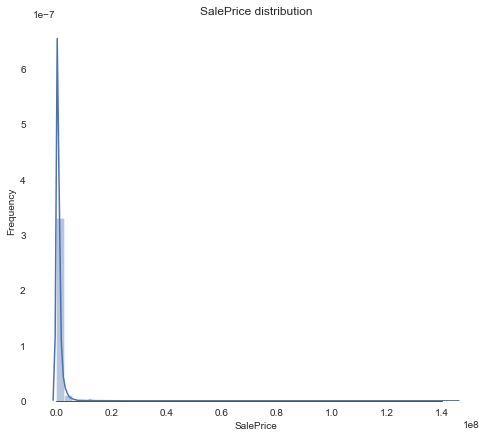

In [127]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_Properties2['Price_Value'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [136]:
df_Properties2.describe()

Zipcode   Price_Value    Cond_Value     IPTU_Value     Area_value  \
count  9.908000e+03  9.879000e+03  9.490000e+03    9235.000000    9731.000000   
mean   6.109927e+07  8.464033e+05  7.369467e+03     202.901137     422.525331   
std    7.150275e+05  2.515270e+06  5.152902e+05    2203.632139   12586.039824   
min    6.000000e+07  1.000000e+00  0.000000e+00       0.000000       0.000000   
25%    6.019234e+07  2.500000e+05  0.000000e+00       0.000000      75.000000   
50%    6.160004e+07  4.800000e+05  0.000000e+00       0.000000     108.000000   
75%    6.176000e+07  8.900000e+05  6.500000e+02       0.000000     178.000000   
max    6.289900e+07  1.450000e+08  5.000000e+07  189000.000000  999888.000000   

       Bedrooms_qty  Bathrooms_qty   Garage_qty  
count   9908.000000    9886.000000  9526.000000  
mean       3.023819       2.974206     2.355343  
std        0.876114       1.286497     1.211674  
min        0.000000       0.000000     0.000000  
25%        2.000000       2.000000     2.000000  
50%        3.000000       3.000000     2.000000  
75%        4.000000       4.000000     3.000000  
max        5.000000       5.000000     5.000000

In [140]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [141]:
df_Properties3 = remove_outliers(df_Properties2,['Price_Value'],3)
df_Properties3.describe()

Working on column: Price_Value


Zipcode   Price_Value    Cond_Value     IPTU_Value     Area_value  \
count  9.842000e+03  9.842000e+03  9.451000e+03    9198.000000    9683.000000   
mean   6.109996e+07  7.669302e+05  2.103267e+03     202.915416     421.615615   
std    7.148723e+05  8.939286e+05  4.603934e+04    2206.756622   12617.141621   
min    6.000000e+07  1.000000e+00  0.000000e+00       0.000000       0.000000   
25%    6.019234e+07  2.500000e+05  0.000000e+00       0.000000      75.000000   
50%    6.160009e+07  4.771120e+05  0.000000e+00       0.000000     108.000000   
75%    6.176000e+07  8.900000e+05  6.500000e+02       0.000000     176.000000   
max    6.289900e+07  8.000000e+06  2.150000e+06  189000.000000  999888.000000   

       Bedrooms_qty  Bathrooms_qty   Garage_qty  
count   9842.000000    9826.000000  9472.000000  
mean       3.020829       2.971301     2.348501  
std        0.870121       1.283519     1.205283  
min        0.000000       0.000000     0.000000  
25%        2.000000       2.000000     2.000000  
50%        3.000000       3.000000     2.000000  
75%        4.000000       4.000000     3.000000  
max        5.000000       5.000000     5.000000

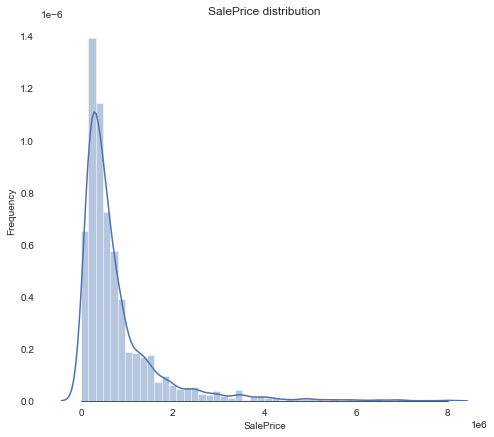

In [142]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_Properties3['Price_Value'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

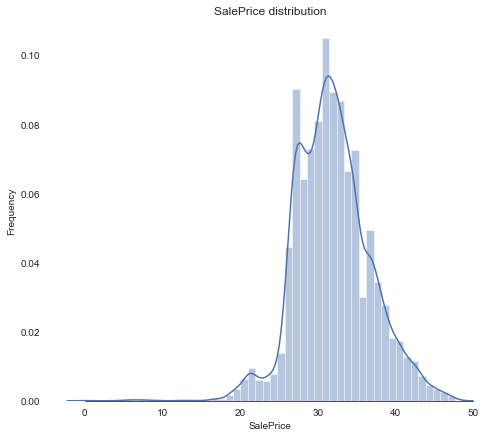

3.163382021800408
-0.9176076656867548
-0.8864578067257725
1.4641944559832998
0.06979594259711046


In [154]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(pd.Series(stats.boxcox(df_Properties3['Price_Value'])[0]), color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()
print(df_Properties3['Price_Value'].skew())
print(np.log(df_Properties3['Price_Value']).skew())
print(np.log1p(df_Properties3['Price_Value']).skew())
print(np.sqrt(df_Properties3['Price_Value']).skew())
print(pd.Series(stats.boxcox(df_Properties3['Price_Value'])[0]).skew())

In [156]:
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9842 entries, 0 to 9976
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9842 non-null   object 
 1   Type             9842 non-null   object 
 2   Cond_Price       9451 non-null   object 
 3   IPTU_Price       9198 non-null   object 
 4   Area             9683 non-null   object 
 5   Bedrooms         9842 non-null   object 
 6   Bathrooms        9826 non-null   object 
 7   Garage           9472 non-null   object 
 8   Property_Detail  7148 non-null   object 
 9   Cond_Detail      6793 non-null   object 
 10  Price            9842 non-null   object 
 11  Zipcode          9842 non-null   int64  
 12  City             9842 non-null   object 
 13  Neighboor        6434 non-null   object 
 14  Address          6307 non-null   object 
 15  Description      9842 non-null   object 
 16  Price_Currency   9842 non-null   object 
 17  Price_Value   

In [160]:
# All categorical columns
object_cols = [col for col in df_Properties3.columns if df_Properties3[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(df_Properties3[col]).issubset(set(df_Properties3[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['Category', 'Type', 'Cond_Price', 'IPTU_Price', 'Area', 'Bedrooms', 'Bathrooms', 'Garage', 'Property_Detail', 'Cond_Detail', 'Price', 'City', 'Neighboor', 'Address', 'Description', 'Price_Currency', 'Cond_Currency', 'IPTU_Currency']

Categorical columns that will be dropped from the dataset: []


In [158]:
print(df_Properties3.shape)
important_columns = ['Category', 'Type','Zipcode','City','Neighboor','Price_Value','Area_value','Bedrooms_qty','Bathrooms_qty','Garage_qty']
all_features = pd.get_dummies(df_Properties3[important_columns]).reset_index(drop=True)
all_features.shape

(9842, 26)


(9842, 257)

In [159]:
all_features

Zipcode  Price_Value  Area_value  Bedrooms_qty  Bathrooms_qty  \
0     61760000     569000.0       150.0             4            4.0   
1     61760000    1350000.0       230.0             4            5.0   
2     61760000     995000.0       210.0             4            4.0   
3     61760000    4000000.0       335.0             4            4.0   
4     61650290      35000.0        50.0             2            1.0   
...        ...          ...         ...           ...            ...   
9837  60813715     850000.0       210.0             3            5.0   
9838  60714273      95000.0        79.0             3            2.0   
9839  60192105     700000.0       117.0             3            4.0   
9840  60830095     599900.0       520.0             3            3.0   
9841  60175045     399000.0        56.0             2            2.0   

      Garage_qty  Category_Apartamentos  Category_Casas  \
0            2.0                      0               1   
1            4.0                      0               1   
2            3.0                      0               1   
3            4.0                      0               1   
4            1.0                      1               0   
...          ...                    ...             ...   
9837         NaN                      0               1   
9838         1.0                      0               1   
9839         2.0                      1               0   
9840         2.0                      0               1   
9841         1.0                      1               0   

      Type_Venda - apartamento cobertura  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   
...                                  ...   
9837                                   0   
9838                                   0   
9839                                   0   
9840                                   0   
9841                                   0   

      Type_Venda - apartamento duplex/triplex  ...  Neighboor_Tangueira  \
0                                           0  ...                    0   
1                                           0  ...                    0   
2                                           0  ...                    0   
3                                           0  ...                    0   
4                                           0  ...                    0   
...                                       ...  ...                  ...   
9837                                        0  ...                    0   
9838                                        0  ...                    0   
9839                                        0  ...                    0   
9840                                        0  ...                    0   
9841                                        0  ...                    0   

      Neighboor_Tauape  Neighboor_Taíba  Neighboor_Timbó  Neighboor_Varjota  \
0                    0                0                0                  0   
1                    0                0                0                  0   
2                    0                0                0                  0   
3                    0                0                0                  0   
4                    0                0                0                  0   
...                ...              ...              ...                ...   
9837                 0                0                0                  0   
9838                 0                0                0                  0   
9839                 0                0                0                  0   
9840                 0                0                0                  0   
9841                 0                0                0                  0   

      Neighboor_Vicente Pinzon  Neighboor_Vila Peri  N

In [244]:
df_CEP_data.to_csv('zipcode_address_lat_long.csv', index=False)

In [3]:
df_CEP_data = pd.read_csv('zipcode_address_lat_long.csv')

In [47]:
df_Properties2

Category                                Type Cond_Price IPTU_Price  \
0     Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   
1     Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   
2            Casas  Venda - casa em condominio fechado   R$ 1.100       R$ 0   
3            Casas  Venda - casa em condominio fechado       R$ 0       R$ 0   
4            Casas  Venda - casa em condominio fechado       R$ 0       R$ 0   
...            ...                                 ...        ...        ...   
7183  Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   
7184  Apartamentos          Venda - apartamento padrão       R$ 0       R$ 0   
7190         Casas         Venda - casa em rua pública       R$ 0       R$ 0   
7194         Casas         Venda - casa em rua pública       R$ 0     R$ 200   
7199  Apartamentos          Venda - apartamento padrão     R$ 900       R$ 0   

      Area  Bedrooms  Bathrooms  Garage  \
0       61         2          2       2   
1      115         3          5       2   
2      520         5          5       4   
3      255         3          4       4   
4      442         5          5       5   
...    ...       ...        ...     ...   
7183   271         5          5       5   
7184    78         3          2       2   
7190   280         5          4       4   
7194   105         3          1       2   
7199   137         3          3       1   

                                        Property_Detail  \
0      Área de serviço, Piscina, Varanda, Churrasqueira   
1                              Varanda, Ar condicionado   
2     Churrasqueira, Piscina, Ar condicionado, Porte...   
3                  Churrasqueira, Porteiro 24h, Piscina   
4                                                   NaN   
...                                                 ...   
7183          Academia, Varanda, Churrasqueira, Piscina   
7184                   Piscina, Churrasqueira, Academia   
7190                                                NaN   
7194                                          Mobiliado   
7199                                                NaN   

                                            Cond_Detail  ...  \
0                                               Piscina  ...   
1                                                   NaN  ...   
2     Academia, Condomínio fechado, Piscina, Portão ...  ...   
3     Piscina, Permitido animais, Academia, Condomín...  ...   
4                                    Condomínio fechado  ...   
...                                                 ...  ...   
7183  Academia, Condomínio fechado, Permitido animai...  ...   
7184  Salão de festas, Academia, Permitido animais, ...  ...   
7190                                                NaN  ...   
7194                                  Permitido animais  ...   
7199                       Portaria, Condomínio fechado  ...   

                                            Description  Price_Currency  \
0     Código do anúncio: AP0072\n\nApartamentos pron...              R$   
1     Código do anúncio: 0026\n\nGolf Ville reúne o ...              R$   
2     Código do anúncio: CS057\n\nCasa 520 m² à vend...              R$   
3     Código do anúncio: GGDGO8\n\nCidade Alpha\n\n*...              R$   
4     Código do anúncio: CA0011\n\nCasa pronta para ...              R$   
...                                                 ...             ...   
7183  Código do anúncio: PALATIUM\n\nPalatium, a exp...              R$   
7184  Código do anúncio: 1RFTVNC\n\nORION FONTENELE ...              R$   
7190  Código do anúncio: CA0208\n\nExcelente Casa no...              R$   
7194  Código do anúncio: 1OJ8VON\n\nA casa no bairro...              R$   
7199  Código do anúncio: 83IAT6\n\nMorar no coração ...              R$   

     Price_Value Cond_Currency Cond_Value IPTU_Currency IPTU_Value  \
0         157902            R$          0            R$          0   
1        1200

In [35]:
df_CEP_data = df_CEP_data.set_index('index')
df_CEP_data

cep                     logradouro  \
index                                                
61601640  61601-640       Rua Maria Carneiro Silva   
61700000  61700-000                            NaN   
61760000        NaN                            NaN   
61651030  61651-030              Rua Adelino Diniz   
61626280  61626-280       Rua Taciano Rocha Pontes   
...             ...                            ...   
60821800  60821-800              Rua Lídia Brigido   
60421100  60421-100               Rua Elcias Lopes   
60150165  60150-165          Avenida Santos Dumont   
60450235  60450-235  Rua Professor Lino Encarnação   
60812575  60812-575                Rua dos Muricis   

                          complemento                  bairro localidade   uf  \
index                                                                           
61601640                          NaN                Curicaca    Caucaia   CE   
61700000                          NaN                     NaN    Aquiraz   CE   
61760000                          NaN                     NaN        NaN  NaN   
61651030                          NaN  Parque Potira (Jurema)    Caucaia   CE   
61626280                          NaN                 Pacheco    Caucaia   CE   
...                               ...                     ...        ...  ...   
60821800                          NaN         Parque Manibura  Fortaleza   CE   
60421100                          NaN                  Itaoca  Fortaleza   CE   
60150165  de 2401 a 3999 - lado ímpar                 Aldeota  Fortaleza   CE   
60450235                  até 574/575            Parquelândia  Fortaleza   CE   
60812575       (Lot Cidade Ecológica)           Edson Queiroz  Fortaleza   CE   

               ibge  gia   ddd   siafi  erro  \
index                                          
61601640  2303709.0  NaN  85.0  1373.0   NaN   
61700000  2301000.0  NaN  85.0  1319.0   NaN   
61760000        NaN  NaN   NaN     NaN  True   
61651030  2303709.0  NaN  85.0  1373.0   NaN   
61626280  2303709.0  NaN  85.0  1373.0   NaN   
...             ...  ...   ...     ...   ...   
60821800  2304400.0  NaN  85.0  1389.0   NaN   
60421100  2304400.0  NaN  85.0  1389.0   NaN   
60150165  2304400.0  NaN  85.0  1389.0   NaN   
60450235  2304400.0  NaN  85.0  1389.0   NaN   
60812575  2304400.0  NaN  85.0  1389.0   NaN   

                                                full_adress  \
index                                                         
61601640   Rua Maria Carneiro Silva, Curicaca, Caucaia - CE   
61700000                                   , , Aquiraz - CE   
61760000                                                NaN   
61651030  Rua Adelino Diniz, Parque Potira (Jurema), Cau...   
61626280    Rua Taciano Rocha Pontes, Pacheco, Caucaia - CE   
...                                                     ...   
60821800  Rua Lídia Brigido, Parque Manibura, Fortaleza ...   
60421100           Rua Elcias Lopes, Itaoca, Fortaleza - CE   
60150165     Avenida Santos Dumont, Aldeota, Fortaleza - CE   
60450235  Rua Professor Lino Encarnação, Parquelândia, F...   
60812575     Rua dos Muricis, Edson Queiroz, Fortaleza - CE   

                                                   location  \
index                                                         
61601640  Rua Maria Carneiro Silva, Curicaca, Caucaia, R...   
61700000  Aquiraz, Região Geográfica Imediata de Fortale...   
61760000                                                NaN   
61651030                                                NaN   
61626280                                                NaN   
...                                                     ...   
60821800  Rua Lídia Brígido, Parque Manibura, Fortaleza,...   
60421100  Rua Elcias Lopes, Itaoca, Fortaleza, Região Ge...   
60150165  Avenida Santos Dumont, Aldeota, Fortaleza, Reg...   
60450235  Rua Professor Lino Encarnação, Parquelândia, F...   
60812575  Rua dos Muricis, Edson Queiroz, Fortaleza, Reg..

In [45]:
def get_point_by_cep(cep):
    return str(df_CEP_data.loc[cep]['point']).replace('(','').replace(', 0.0)','')
def get_lat(lat_long):
    if lat_long != 'nan':
        return str(lat_long).split(',')[0]
    else:
        return ''
def get_long(lat_long):
    if lat_long != 'nan':
        return str(lat_long).split(',')[1]
    else: 
        return ''


In [46]:
df_Properties2['point'] = df_Properties2['Zipcode'].apply(get_point_by_cep)
df_Properties2['lat'] = df_Properties2['point'].apply(get_lat)
df_Properties2['long'] = df_Properties2['point'].apply(get_long)

In [71]:
df_Properties3 = df_Properties2.reset_index()[['index','Area','Bedrooms','Bathrooms','Garage','Price_Value','lat','long']]
df_Properties3 = df_Properties3[(df_Properties3['Area'] > 40) & (df_Properties3['Area'] < 1000) & (df_Properties3['Price_Value'] > 100000) & (df_Properties3['Price_Value'] < 2000000) & (df_Properties3['lat'] != '')]
df_Properties3

index  Area  Bedrooms  Bathrooms  Garage  Price_Value         lat  \
0         0    61         2          2       2       157902  -3.7173205   
1         1   115         3          5       2      1200000  -3.9063117   
5         5   145         3          3       2       615000  -3.9063117   
6         6    68         2          2       1       510000  -3.9063117   
9        11   918         5          5       5      1100000  -3.9063117   
...     ...   ...       ...        ...     ...          ...         ...   
3531   7177   120         3          3       1       335000  -3.8090754   
3533   7180   280         3          3       5       415000  -3.7721067   
3535   7184    78         3          2       2       634160  -3.7374384   
3536   7190   280         5          4       4       770000  -3.7769942   
3538   7199   137         3          3       1       339000  -3.7282273   

              long  
0      -38.6601535  
1       -38.387504  
5       -38.387504  
6       -38.387504  
9       -38.387504  
...            ...  
3531   -38.5602514  
3533   -38.5529254  
3535   -38.5614135  
3536   -38.4523094  
3538   -38.4925786  

[1712 rows x 8 columns]

In [72]:
df_Properties3.describe()

index         Area     Bedrooms    Bathrooms       Garage  \
count  1712.000000  1712.000000  1712.000000  1712.000000  1712.000000   
mean   3122.839369   129.189252     2.925234     2.837617     2.161215   
std    2158.746561    99.992281     0.839007     1.193901     1.118231   
min       0.000000    41.000000     1.000000     1.000000     0.000000   
25%    1238.750000    72.000000     2.000000     2.000000     1.000000   
50%    2554.000000    98.000000     3.000000     3.000000     2.000000   
75%    5046.000000   144.000000     3.000000     4.000000     3.000000   
max    7199.000000   918.000000     5.000000     5.000000     5.000000   

        Price_Value  
count  1.712000e+03  
mean   5.913836e+05  
std    4.440148e+05  
min    1.050000e+05  
25%    2.300000e+05  
50%    4.700000e+05  
75%    8.000000e+05  
max    1.999999e+06

In [73]:
df_Properties3.to_csv('data_to_tableau.csv', index=False, sep=';')

In [75]:
df_Properties3['lat'] = pd.to_numeric(df_Properties3['lat'])
df_Properties3['long'] = pd.to_numeric(df_Properties3['long'])
df_Properties3.corr()

index      Area  Bedrooms  Bathrooms    Garage  Price_Value  \
index        1.000000 -0.025708  0.061259   0.114112 -0.001306     0.052597   
Area        -0.025708  1.000000  0.635574   0.586014  0.702318     0.445761   
Bedrooms     0.061259  0.635574  1.000000   0.704953  0.594066     0.467104   
Bathrooms    0.114112  0.586014  0.704953   1.000000  0.593104     0.619676   
Garage      -0.001306  0.702318  0.594066   0.593104  1.000000     0.439800   
Price_Value  0.052597  0.445761  0.467104   0.619676  0.439800     1.000000   
lat          0.394668 -0.066023 -0.024677  -0.014511 -0.121346    -0.013254   
long        -0.015022  0.138476  0.156171   0.265292  0.132618     0.310548   

                  lat      long  
index        0.394668 -0.015022  
Area        -0.066023  0.138476  
Bedrooms    -0.024677  0.156171  
Bathrooms   -0.014511  0.265292  
Garage      -0.121346  0.132618  
Price_Value -0.013254  0.310548  
lat          1.000000 -0.576911  
long        -0.576911  1.000000

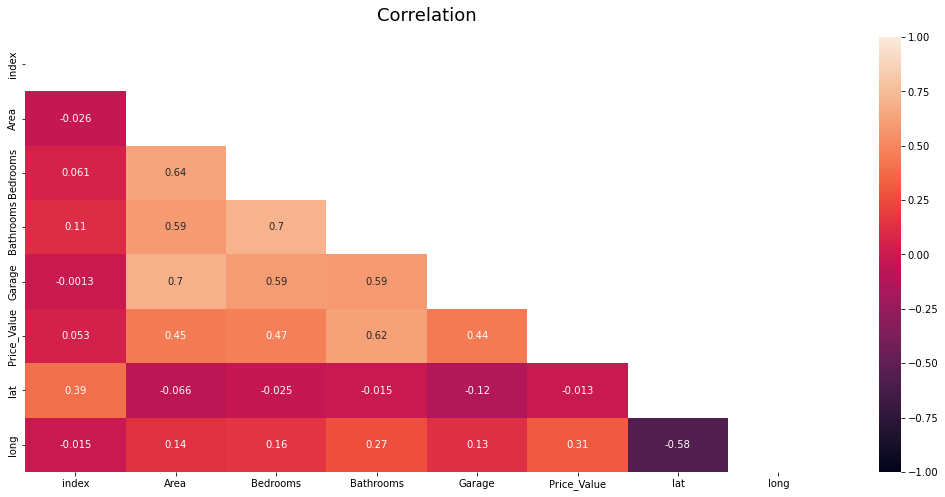

In [81]:
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(df_Properties3.corr(), dtype=bool))
heatmap = sns.heatmap(df_Properties3.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16);

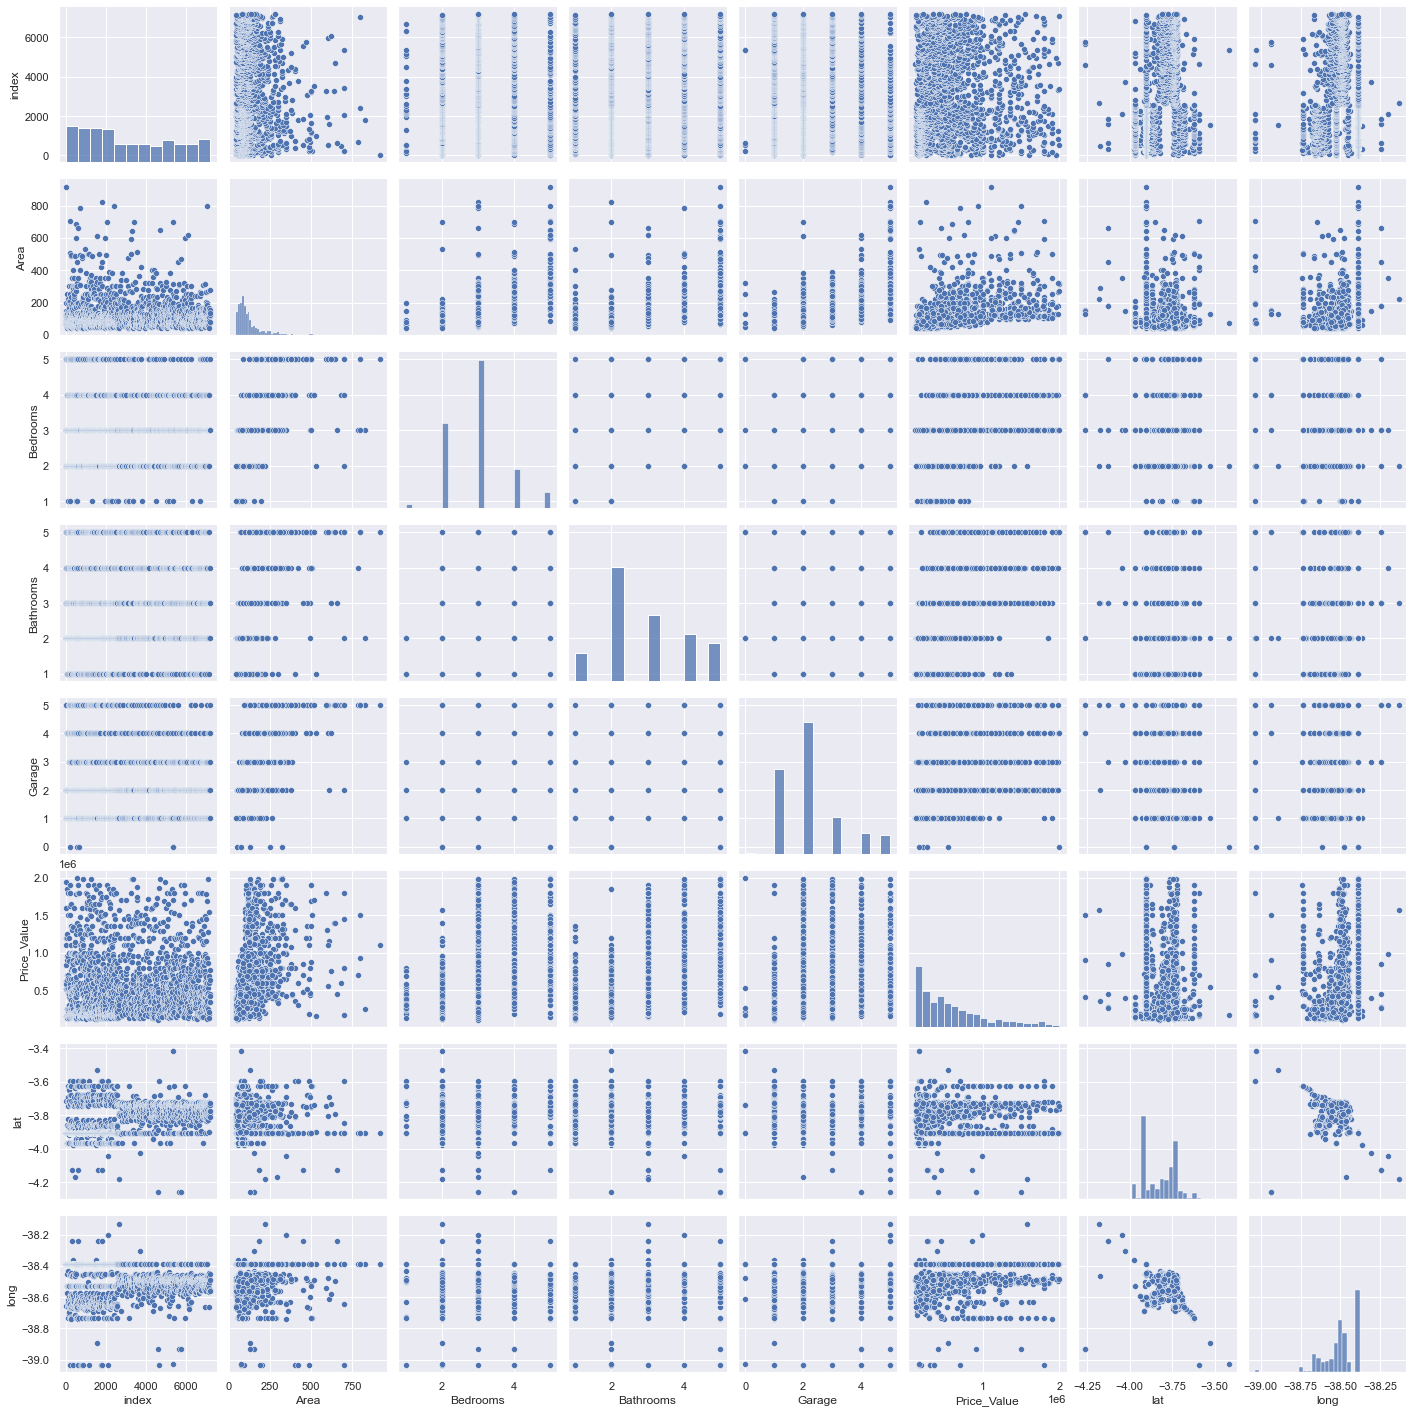

In [84]:
sns.set()
sns.pairplot(df_Properties3, height = 2.5)
plt.show();

In [41]:
df_Properties2.to_csv('data_to_tableau.csv', index=False, sep=';')

In [52]:
import matplotlib.pyplot as plt # visualization library
import chart_studio.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object

In [51]:
!pip install chart_studio

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=7976d65b214fd37b80fc00bbfc03b6054c5ee5aac50a77f84a765838802e9d11
  Stored in directory: c:\users\henrique.innecco\appdata\local\pip\cache\wheels\ce\18\7f\e9527e3e66db1456194ac7f61eb3211068c409edceecff2d31
Successfully built retrying


In [56]:
data = [dict(
    type='scattergeo',
    lon = df_Properties2['long'],
    lat = df_Properties2['lat'],
    mode = 'markers',
    marker=dict(
        sizeref = 1,
        size= 10 ,
        line = dict(width=1,color = "rosybrown"),
        symbol = 'cross',
        opacity = 0.7),
)]

layout = dict(
    title = 'House Locations ',
    hovermode='closest',
    geo = dict(showframe=True, showland=True, showcoastlines=True, showcountries=True,showsubunits=True, scope='south america',
               countrywidth=1, projection=dict(type='miller'),
              landcolor = 'rgb(217, 217, 217)',
              subunitwidth=1,
              showlakes = True,
              lakecolor = 'firebrick',
              countrycolor="rgb(5, 5, 5)")
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)